## Problem Set #1: 
#### Problem Category (3) Identifying at-risk populations
# How does certificate of occupancy issuance correlates with building violation complaints?

#### _Backround_
A Certificate of Occupancy (CO) states a building’s legal use and/or type of permitted occupancy. New buildings must have a CO, and existing buildings must have a current or amended CO when there is a change in use, egress or type of occupancy.  (from [nyc.gov](https://www1.nyc.gov/site/buildings/homeowner/certificate-of-occupancy.page))


#### _Research Objectives_
My motivation for this HW assignment was to analyze the impact of the number of residential certificates of occupancy issuance on the number of building violation complaints, if any, and by this to identify areas that should get more attention regarding building codes and building use validation.

I pre assumed that an area with a very low number of certificates of occupancy issued over a year (meaning, an area that is less developing / renewing) will also have a relatively large number of building violation (illegal conversion) complaints. 
I also guessed there will be anomalies, so as highly renewing areas with large number of CO's and a large number of building violation complaints.


#### _Data Inventory_
The **building violation complaints data** is taken from 311 open data; The certificate of occupancy issuance data is taken from DOB open data. All data in this research rely on data from year 2016 and were cleaned to focus only in residential information. Any personal information was excluded from the datasets pre-importing. 

The 311 complaints data were filtered to include **Building/Use complaint type** only, and then filtered again by descriptor to include **illegal conversion** of non residential buildings/units to residential without obtaining approval from the New York City Department of Buildings (excluding illegal vehicle storage, for example). 

For more information regarding illegal conversion: [nyc.gov](https://www1.nyc.gov/site/buildings/renter/illegal-conversions-vacates.page)

The **DOB Certificate of Occupancy data** were cleaned from any unuseful / private data. Both **temporary** and **final** certificate types were included. 

____________

## Data import and organization


In [2]:
from __future__ import print_function

import numpy as np
import statsmodels.formula.api as smf
import pylab as pl
import pandas as pd
import geopandas as gp
from shapely.geometry import Point

import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Importing data from 311 Open Data

The 311 service request data were cleaned before importing, filtering for year 2016 only and for complaint type Building Violation, as explained above.

In [3]:
df311 = pd.read_csv("311_Service_Requests_from_2010_to_Present.csv")
df311.tail()

,Created Date,Complaint Type,Descriptor,Incident Zip,Community Board,Borough,Location
24836,12/31/2016 09:10:50 PM,Building/Use,Illegal Conversion Of Residential Building/Space,11361.0,11 QUEENS,QUEENS,"(40.75975110443776, -73.78007235597971)"
24837,12/31/2016 09:13:56 PM,Building/Use,Illegal Conversion Of Residential Building/Space,11361.0,11 QUEENS,QUEENS,"(40.760078912354956, -73.77925547769352)"
24838,12/31/2016 09:33:44 PM,Building/Use,Illegal Conversion Of Residential Building/Space,10314.0,02 STATEN ISLAND,STATEN ISLAND,"(40.59457056435304, -74.16376975933301)"
24839,12/31/2016 10:40:38 PM,Building/Use,Illegal Conversion Of Residential Building/Space,NaN,Unspecified BROOKLYN,BROOKLYN,NaN
24840,12/31/2016 10:54:07 PM,Building/Use,Illegal Conversion Of Residential Building/Space,11416.0,09 QUEENS,QUEENS,"(40.680485315217275, -73.86361860556892)"


In [4]:
# converting date to datetime format, date only
df311['datehour'] = (pd.to_datetime(df311['Created Date']))

In [5]:
df311['date'] = df311['datehour'].dt.date

In [6]:
df311 = df311.dropna(0)
df311['Incident Zip'] = df311['Incident Zip'].apply(np.int64)
df311.tail()

,Created Date,Complaint Type,Descriptor,Incident Zip,Community Board,Borough,Location,datehour,date
24835,12/31/2016 08:51:38 PM,Building/Use,Illegal Conversion Of Residential Building/Space,11377,02 QUEENS,QUEENS,"(40.734940249665236, -73.89982515613181)",2016-12-31 20:51:38,2016-12-31
24836,12/31/2016 09:10:50 PM,Building/Use,Illegal Conversion Of Residential Building/Space,11361,11 QUEENS,QUEENS,"(40.75975110443776, -73.78007235597971)",2016-12-31 21:10:50,2016-12-31
24837,12/31/2016 09:13:56 PM,Building/Use,Illegal Conversion Of Residential Building/Space,11361,11 QUEENS,QUEENS,"(40.760078912354956, -73.77925547769352)",2016-12-31 21:13:56,2016-12-31
24838,12/31/2016 09:33:44 PM,Building/Use,Illegal Conversion Of Residential Building/Space,10314,02 STATEN ISLAND,STATEN ISLAND,"(40.59457056435304, -74.16376975933301)",2016-12-31 21:33:44,2016-12-31
24840,12/31/2016 10:54:07 PM,Building/Use,Illegal Conversion Of Residential Building/Space,11416,09 QUEENS,QUEENS,"(40.680485315217275, -73.86361860556892)",2016-12-31 22:54:07,2016-12-31


#### Importing data from DOB Open Data

The Certificate of Occupancy Issuance data were cleaned before importing, filtering for year 2016 only. 

In [7]:
dfDOB = pd.read_csv("DOB_Certificate_Of_Occupancy.csv")
dfDOB.head()

,C_O_ISSUE_DATE,BOROUGH,POSTCODE,ISSUE_TYPE
0,12/09/2016,Manhattan,10002,Temporary
1,02/08/2016,Manhattan,10022,Temporary
2,04/29/2016,Manhattan,10022,Temporary
3,08/16/2016,Manhattan,10022,Temporary
4,11/03/2016,Manhattan,10019,Temporary


In [8]:
# converting date to datetime format, date only
dfDOB['date'] = (pd.to_datetime(dfDOB['C_O_ISSUE_DATE']))

In [9]:
# cleaning non-residential permits
dfDOB = dfDOB.dropna(0)
dfDOB.head()

,C_O_ISSUE_DATE,BOROUGH,POSTCODE,ISSUE_TYPE,date
0,12/09/2016,Manhattan,10002,Temporary,2016-12-09
1,02/08/2016,Manhattan,10022,Temporary,2016-02-08
2,04/29/2016,Manhattan,10022,Temporary,2016-04-29
3,08/16/2016,Manhattan,10022,Temporary,2016-08-16
4,11/03/2016,Manhattan,10019,Temporary,2016-11-03


In [14]:
# groupby and count complaints and residential CO's by zipcode
BVcomplaints = pd.DataFrame({"BV Complaints": df311.groupby(["Incident Zip"]).size()}).reset_index()
ResCO = pd.DataFrame({"Res CO's": dfDOB.groupby(["POSTCODE"]).size()}).reset_index()

# renaming zipcode headers to fit both dataframes 
BVcomplaints.columns = ['Zip Code', 'BV Complaints']
ResCO.columns = ['Zip Code', "Res CO's"]

# merging dataframes
CO_vs_BVcomp = pd.merge(ResCO, BVcomplaints, on="Zip Code")
CO_vs_BVcomp.head()

,Zip Code,Res CO's,BV Complaints
0,10001,361,67
1,10002,142,178
2,10003,299,78
3,10004,91,2
4,10005,93,4


----------

## Descriptive Statistics
In order to assess and compare their types of distribution, I first plotted each dataset histogram and distplot. 

I found out than their **do not match**.

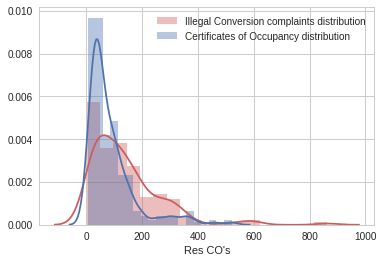

In [19]:
sns.distplot(CO_vs_BVcomp['BV Complaints'], color="IndianRed", label='Illegal Conversion complaints distribution');
sns.distplot(CO_vs_BVcomp["Res CO's"], label='Certificates of Occupancy distribution');
sns.set_style("whitegrid")
pl.legend()

----------

Then, I used **bar plot** for each data, grouped by **Zip Codes** as showed in the combined dataframe, and layered the DOB plot (_blue bars_) over the 311 plot (_red bars_). 
Since the number of bars is big, I also plotted 2 figures to two of NYC five boroughs, using the same method. 

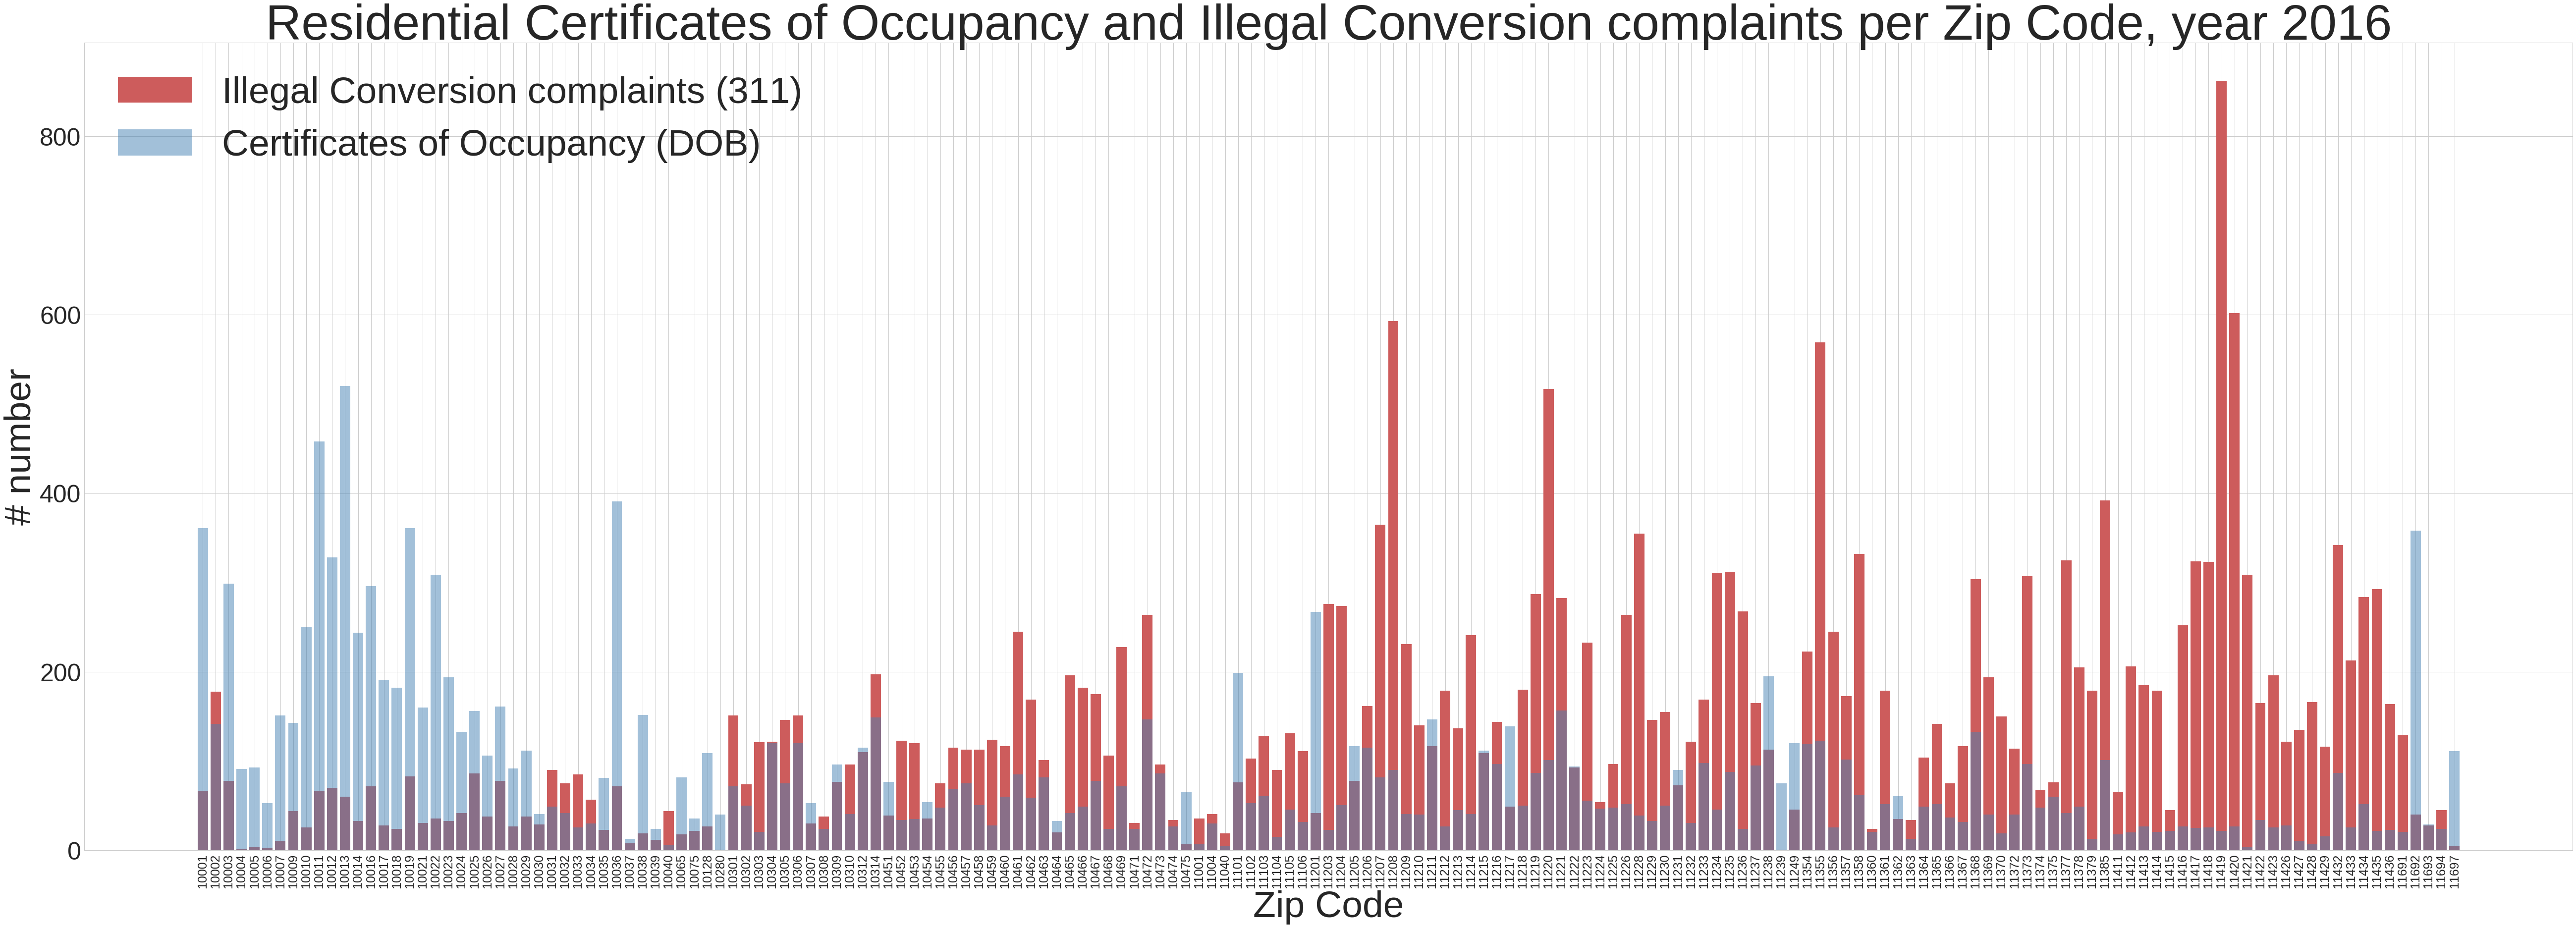

In [18]:
pl.figure(figsize = (90,30))

pl.bar(range(len(CO_vs_BVcomp)), CO_vs_BVcomp['BV Complaints'], align='center', color="IndianRed",\
label='Illegal Conversion complaints (311)')
ax = pl.bar(range(len(CO_vs_BVcomp)), CO_vs_BVcomp["Res CO's"], align='center', color="SteelBlue", alpha=0.5,\
label='Certificates of Occupancy (DOB)')
pl.xticks(range(len(CO_vs_BVcomp)), CO_vs_BVcomp["Zip Code"], fontsize = 25, rotation=90)
pl.yticks(fontsize = 50)

sns.set_style("whitegrid")
pl.xlabel('Zip Code', fontsize=75)
pl.ylabel('# number', fontsize=75)
pl.title('Residential Certificates of Occupancy and Illegal Conversion complaints per Zip Code, year 2016', fontsize=100)
pl.legend(prop={'size': 75})

----------

In [20]:
# prepering data structure for the divided plots per borough
# creating a df of Manhattan and Brooklyn
CO_vs_BVcompMAN = CO_vs_BVcomp[:77]
CO_vs_BVcompBR = CO_vs_BVcomp[86:124]
CO_vs_BVcompBR.tail()

,Zip Code,Res CO's,BV Complaints
119,11236,24,268
120,11237,95,165
121,11238,195,113
122,11239,75,1
123,11249,120,46


#### ** Manhattan

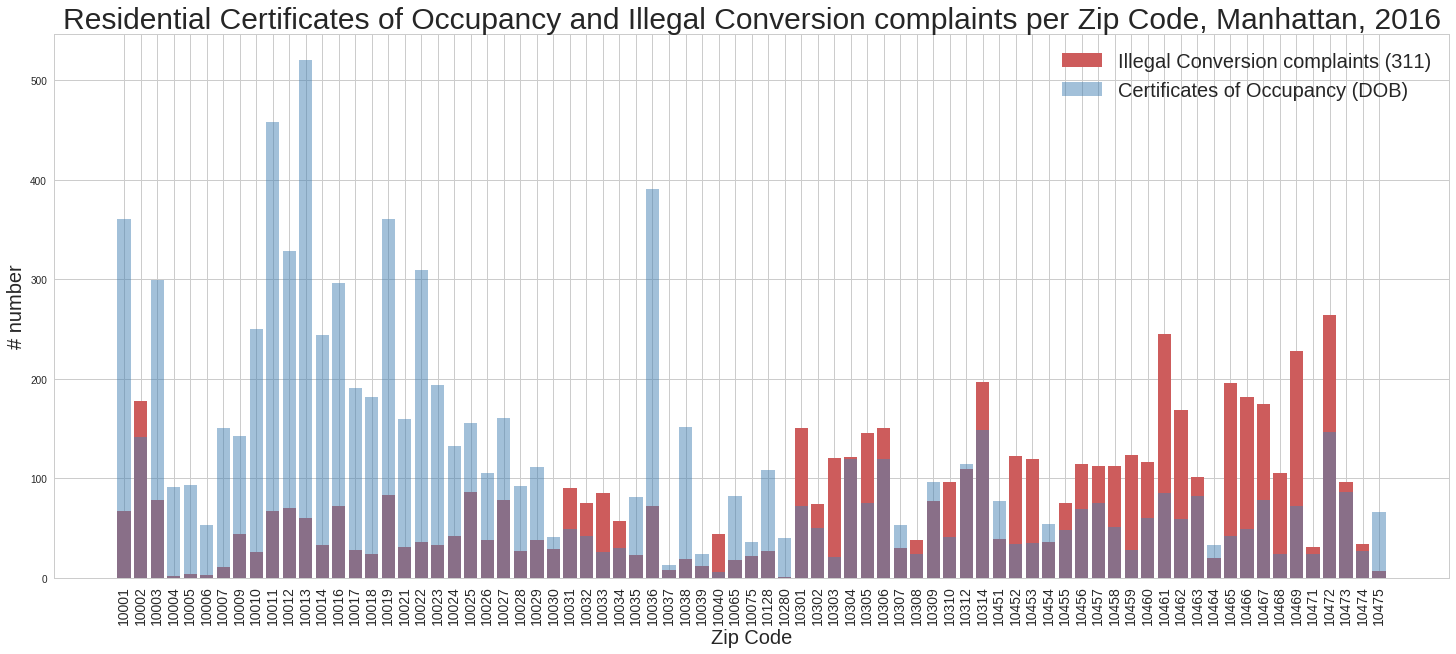

In [21]:
pl.figure(figsize = (25,10))

ax = pl.bar(range(len(CO_vs_BVcompMAN)), CO_vs_BVcompMAN['BV Complaints'], align='center', color="IndianRed", label='Illegal Conversion complaints (311)')
ax0 = pl.bar(range(len(CO_vs_BVcompMAN)), CO_vs_BVcompMAN["Res CO's"], align='center', color="SteelBlue", alpha=0.5, label='Certificates of Occupancy (DOB)')
pl.xticks(range(len(CO_vs_BVcompMAN)), CO_vs_BVcompMAN["Zip Code"], fontsize = 14, rotation=90)

pl.xlabel('Zip Code', fontsize=20)
pl.ylabel('# number', fontsize=20)
pl.title('Residential Certificates of Occupancy and Illegal Conversion complaints per Zip Code, Manhattan, 2016', fontsize=30)
pl.legend(prop={'size': 20})
sns.set_style("whitegrid")

#### ** Brooklyn

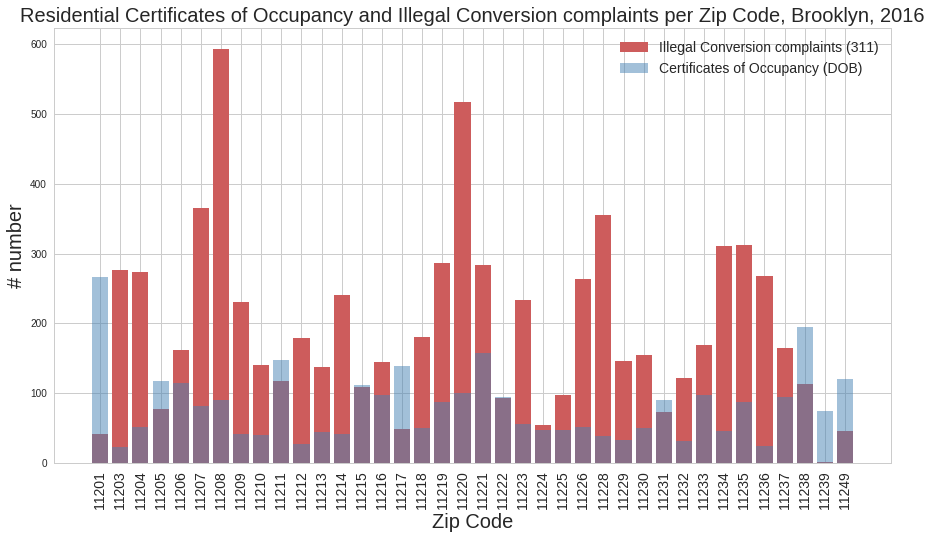

In [22]:
pl.figure(figsize = (15,8))

ax = pl.bar(range(len(CO_vs_BVcompBR)), CO_vs_BVcompBR['BV Complaints'], align='center', color="IndianRed", label='Illegal Conversion complaints (311)')
ax0 = pl.bar(range(len(CO_vs_BVcompBR)), CO_vs_BVcompBR["Res CO's"], align='center', color="SteelBlue", alpha=0.5, label='Certificates of Occupancy (DOB)')
pl.xticks(range(len(CO_vs_BVcompBR)), CO_vs_BVcompBR["Zip Code"], fontsize = 14, rotation=90)

pl.xlabel('Zip Code', fontsize=20)
pl.ylabel('# number', fontsize=20)
pl.title('Residential Certificates of Occupancy and Illegal Conversion complaints per Zip Code, Brooklyn, 2016', fontsize=20)
pl.legend(prop={'size': 14})
sns.set_style("whitegrid")

----------

# Discussion


Unfortunately it was hard to extract a clear impact of any of the datasets on the other; There are Zip Codes with a high number of BV complaints and a low number of CO's and also of the opposite, though one cannot say it is clear and compelling. 

I continued with spatial visualization and statistical analysis.

----------

# Visualization

For the visualization of the BV complaints I tried to use **carto**, worked according to a [tutorial](https://carto.com/learn/guides/analysis/intersect-second-layer) to help me  implement the complaints data into the map, mapped by their zip codes. 

Unfortunately I did not succeed with the mapping; using geopandas and shapefile didn't gain success either.

__________

## Analysis: 
Running a correlation analysis and linear regression to assess the correlation between the number of certificates of occupation issued and the number of building violation complaints.

### Finding Correlation Coefficient

In [96]:
mean_ResCO = CO_vs_BVcomp["Res CO's"].mean()
mean_BVcomplaints = CO_vs_BVcomp['BV Complaints'].mean()
std_ResCO = CO_vs_BVcomp["Res CO's"].std()
std_BVcomplaints = CO_vs_BVcomp['BV Complaints'].std()

print (mean_ResCO, mean_BVcomplaints, std_ResCO, std_BVcomplaints)

86.3542857143 139.777142857 87.5652149184 127.076461474


In [97]:
len(CO_vs_BVcomp)

175

In [98]:
# calculating covariance
cov = []
for i in range(len(CO_vs_BVcomp)):
    cov.append((CO_vs_BVcomp["Res CO's"][i] - mean_ResCO)*(CO_vs_BVcomp['BV Complaints'][i] - mean_BVcomplaints))
    
cov = np.mean(cov)
cov

-2039.6924734693878

In [99]:
# Pearson's correlation coefficient:

corr = cov / (std_ResCO * std_BVcomplaints)
corr

-0.18330232023679296

In [100]:
CO_vs_BVcomp_corr = CO_vs_BVcomp[["Res CO's",'BV Complaints']]
CO_vs_BVcomp_corr.corr()

,Res CO's,BV Complaints
Res CO's,1.000000,-0.184356
BV Complaints,-0.184356,1.000000


In [101]:
BVcomp = CO_vs_BVcomp['BV Complaints']
CO = CO_vs_BVcomp["Res CO's"]

In [102]:
lm = smf.ols(formula = 'BVcomp~CO', data = CO_vs_BVcomp).fit()

print(lm.params)
print(lm.rsquared)

Intercept    162.880450
CO            -0.267541
dtype: float64
0.0339870543005


In [103]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BVcomp   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     6.087
Date:                Mon, 09 Oct 2017   Prob (F-statistic):             0.0146
Time:                        22:54:41   Log-Likelihood:                -1092.6
No. Observations:                 175   AIC:                             2189.
Df Residuals:                     173   BIC:                             2196.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    162.8805     13.317     12.231      0.000     136.595     189.166
CO            -0.2675      0.108     -2.467      0.015      -0.482      -0.053
==============================================================================
Omnibus:                       96.014   Durbin-Watson:                   1.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              479.773
Skew:                           2.089   Prob(JB):                    6.59e-105
Kurtosis:                       9.953   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

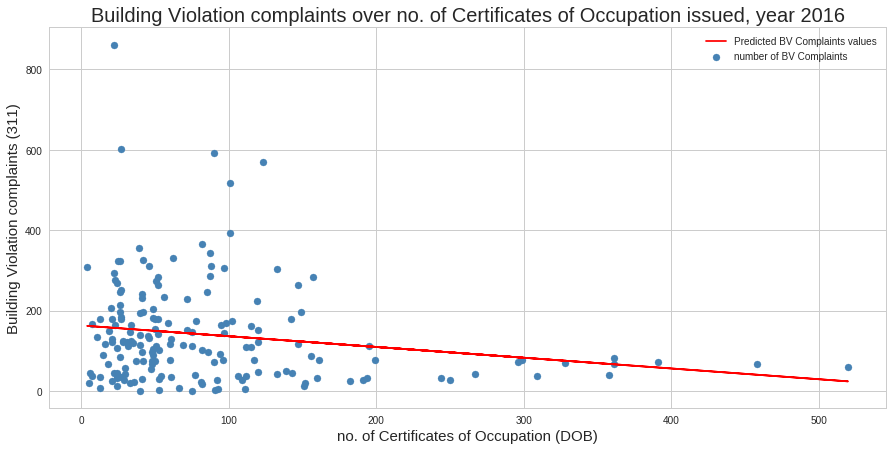

In [110]:
# visualizing 

pl.figure(figsize = (15,7))
pl.scatter(CO_vs_BVcomp["Res CO's"],CO_vs_BVcomp['BV Complaints'], label = 'number of BV Complaints', color = 'SteelBlue')
pl.plot(CO_vs_BVcomp["Res CO's"],lm.predict(), color = 'red', label = 'Predicted BV Complaints values')
pl.xlabel("no. of Certificates of Occupation (DOB)", fontsize = 15)
pl.ylabel('Building Violation complaints (311)', fontsize = 15)
pl.title('Building Violation complaints over no. of Certificates of Occupation issued, year 2016', fontsize = 20)
pl.legend()

### Linear regression

In [105]:
CO_vs_BVcomp['logCO'] = np.log(CO_vs_BVcomp["Res CO's"])
CO_vs_BVcomp['logcomp'] = np.log(CO_vs_BVcomp['BV Complaints'])
CO_vs_BVcomp.tail()

,Zip Code,Res CO's,BV Complaints,logCO,logcomp
170,11691,21,129,3.044522,4.859812
171,11692,358,40,5.880533,3.688879
172,11693,29,28,3.367296,3.332205
173,11694,24,45,3.178054,3.806662
174,11697,111,5,4.709530,1.609438


Intercept    5.045014
logCO       -0.139435
dtype: float64
0.0122349734485


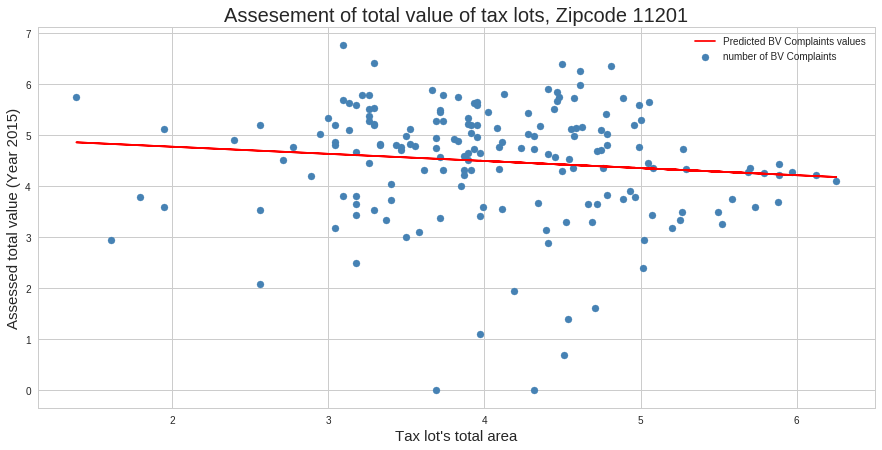

In [109]:
lm2 = smf.ols(formula = 'logcomp~logCO', data = CO_vs_BVcomp).fit()

print(lm2.params)
print(lm2.rsquared)

# visualizing 

pl.figure(figsize = (15,7))
pl.scatter(CO_vs_BVcomp['logCO'],CO_vs_BVcomp['logcomp'], label = 'number of BV Complaints', color = 'SteelBlue')
pl.plot(CO_vs_BVcomp['logCO'],lm2.predict(), color = 'red', label = 'Predicted BV Complaints values')
pl.xlabel("Tax lot's total area", fontsize = 15)
pl.ylabel('Assessed total value (Year 2015)', fontsize = 15)
pl.title('Assesement of total value of tax lots, Zipcode 11201', fontsize = 20)
pl.legend()

____________________

## Conclusion and optional future research 

The analysis turned to be insufficient to provide a predictive model for the chosen question.

An optional interesting factor to be included in future relevant research could be, in my opinion, averaged income of every zip code, excluding very high income areas from the analysis. The assumption behind this approace is that very wealthy people, in their home in which they live, do not usually add residential units and/or converting non-residential area to residential. Moreover, they do not complaint about these kind of data around their homes.

By this, I imagine, we might find a stronger, more reliable correlation between the two sets of data.

_____________________